###PREPARE

In [ ]:
#Prepare lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as ss
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.optimize as opt

###GENERATE DATA

In [ ]:
holiday= ['01/22/2023','02/18/2023','03/22/2023','04/07/2023','04/22/2023','05/18/2023','06/01/2023','06/29/2023', '07/19/2023']

def days_(td):
    return td.days

def gen_df (m, scale, app_status, services):
  x = np.arange(10, 1000)
  prob = ss.norm.pdf(x, m, scale)
  prob = prob / prob.sum() # normalize the probabilities so their sum is 1
  total_application = np.random.choice(x, size = 181, p = prob)

  df = pd.DataFrame({'date': pd.date_range(start='01/01/2023', end='06/30/2023')
                    , 'total_application': total_application
                    , 'status_application': pd.Index([app_status]).repeat(181)
                    , 'potential_revenue': pd.Index([0]).repeat(181)
                    , 'kredivo_services': pd.Index([services]).repeat(181)
                    , 'diff_next_event': pd.date_range(start='12/31/2023', periods =1).repeat(181)})

  difd = pd.date_range(start='12/31/2023', periods =1)- pd.date_range(start='01/01/2023', periods =1)
  difd_int = 0

  c = 0
  dif = pd.DataFrame()
  for k in pd.to_datetime(df['date']):
    for i in pd.to_datetime(holiday):
      c += 1
      difd = i - k
      difd_int = days_(difd)
      dif = pd.concat([dif, pd.DataFrame({'date': [k], 'holiday': [i], 'diff_next_event':[difd_int]}, index=[c])], ignore_index=False)


  dif = dif[dif['diff_next_event']>0]
  dif['rank'] = dif.groupby('date')['diff_next_event'].rank(method="first", ascending=True)
  dif = dif[dif['rank']==1].reset_index()

  return pd.concat([df.drop(columns=['diff_next_event']),dif['diff_next_event']],axis=1)

df = pd.concat([gen_df(650, 300, 'success', 'A'), gen_df(100, 30, 'rejected', 'A'), gen_df(90, 25, 'cancel', 'A'), gen_df(300, 100, 'pending', 'A'),
                gen_df(650, 300, 'success', 'B'), gen_df(100, 30, 'rejected', 'B'), gen_df(90, 25, 'cancel', 'B'), gen_df(300, 100, 'pending', 'B')], ignore_index=True)

df

,date,total_application,status_application,potential_revenue,kredivo_services,diff_next_event
0,2023-01-01,65,success,0,A,21
1,2023-01-02,278,success,0,A,20
2,2023-01-03,406,success,0,A,19
3,2023-01-04,758,success,0,A,18
4,2023-01-05,213,success,0,A,17
...,...,...,...,...,...,...
1443,2023-06-26,409,pending,0,B,3
1444,2023-06-27,198,pending,0,B,2
1445,2023-06-28,240,pending,0,B,1
1446,2023-06-29,376,pending,0,B,20


In [ ]:
# Find all unique value of columns need encoding
u_status_application= np.unique(df['status_application'])
u_kredivo_services = np.unique(df['kredivo_services'])


# Match initial label with new index encoded by LabelEncoder function
le = LabelEncoder()
label_status_application = le.fit_transform(df['status_application'])
mapping_status_application = {index: label for index, label in
                  enumerate(le.classes_)}

label_kredivo_services = le.fit_transform(df['kredivo_services'])
mapping_kredivo_services = {index: label for index, label in
                  enumerate(le.classes_)}
label_date = le.fit_transform(df['date'])
mapping_date = {index: label for index, label in
                  enumerate(le.classes_)}

df['date'] = label_date


#One hot encoding
status_application_onehot = pd.get_dummies(df['status_application'], prefix='status_application')
kredivo_services_onehot = pd.get_dummies(df['kredivo_services'], prefix='kredivo_services')

#Concatenate one hot encoding column to dataset
endf = pd.concat([df[['date', 'total_application', 'diff_next_event']]
                     , status_application_onehot, kredivo_services_onehot,df[['potential_revenue']]], axis=1)
endf

,date,total_application,diff_next_event,status_application_cancel,status_application_pending,status_application_rejected,status_application_success,kredivo_services_A,kredivo_services_B,potential_revenue
0,0,65,21,0,0,0,1,1,0,0
1,1,278,20,0,0,0,1,1,0,0
2,2,406,19,0,0,0,1,1,0,0
3,3,758,18,0,0,0,1,1,0,0
4,4,213,17,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1443,176,409,3,0,1,0,0,0,1,0
1444,177,198,2,0,1,0,0,0,1,0
1445,178,240,1,0,1,0,0,0,1,0
1446,179,376,20,0,1,0,0,0,1,0


In [ ]:
##Generate formula data
def revenue_value (row):
  if row['date'] < 90:
    return row['potential_revenue']
  else:
    return 0

endf['potential_revenue'] = np.random.randint(100, 300, df.shape[0]) + endf['total_application']*endf['status_application_success']*100*np.log10(endf['total_application'])
+ endf['kredivo_services_A']*1.2*np.log10(endf['total_application'])*endf['kredivo_services_B']*0.8 - endf['kredivo_services_B']*0.6 + (3/endf['diff_next_event'])**2*5

endf['potential_revenue'] = endf.apply (lambda row: revenue_value(row), axis=1)


def cost_value (row):
  if row['date'] > 90:
    return 0
  elif row['total_application'] <= 100:
    return (200 + np.random.randint(0, 10)) *row['total_application']
  elif row['total_application'] > 100 and row['total_application'] <= 500:
    return (160 + np.random.randint(0, 10)) *row['total_application']
  else:
    return (100 + np.random.randint(0, 10)) *row['total_application']

endf['cost_to_run_kredivo_services'] = endf.apply (lambda row: cost_value(row), axis=1)
endf

,date,total_application,diff_next_event,status_application_cancel,status_application_pending,status_application_rejected,status_application_success,kredivo_services_A,kredivo_services_B,potential_revenue,cost_to_run_kredivo_services
0,0,65,21,0,0,0,1,1,0,12020.936818,13130.0
1,1,278,20,0,0,0,1,1,0,68176.445327,46704.0
2,2,406,19,0,0,0,1,1,0,106093.156963,66584.0
3,3,758,18,0,0,0,1,1,0,218530.925787,78832.0
4,4,213,17,0,0,0,1,1,0,49725.485553,34506.0
...,...,...,...,...,...,...,...,...,...,...,...
1443,176,409,3,0,1,0,0,0,1,0.000000,0.0
1444,177,198,2,0,1,0,0,0,1,0.000000,0.0
1445,178,240,1,0,1,0,0,0,1,0.000000,0.0
1446,179,376,20,0,1,0,0,0,1,0.000000,0.0


In [ ]:
# Save feature dataset và label to numpy array
npdf = endf[endf['date']<90].to_numpy()
X = npdf[:,0:9]
y = npdf[:,9:11]


In [ ]:
#Split the data into training and valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2)

#Define model
RegModel = RandomForestRegressor(n_estimators=100,criterion='squared_error')

#Printing all the parameters of Random Forest
print(RegModel)

#Creating the model on Training Data
RF=RegModel.fit(X_train,y_train)
prediction=RF.predict(X_valid)

#Measuring Goodness of fit in Training data
print('R2 Value:',metrics.r2_score(y_train, RF.predict(X_train)))

# #Measuring accuracy on Testing Data
print('Accuracy Revenue',round(100 - (np.mean(np.abs(y_valid[:,0] - prediction[:,0]) / y_valid[:,0])) * 100,4), '%')
print('Accuracy Cost',round(100 - (np.mean(np.abs(y_valid[:,1] - prediction[:,1])/ y_valid[:,1])) * 100,4), '%')


RandomForestRegressor()
R2 Value: 0.9994228384000194
Accuracy Revenue 79.0847 %
Accuracy Cost 97.9991 %


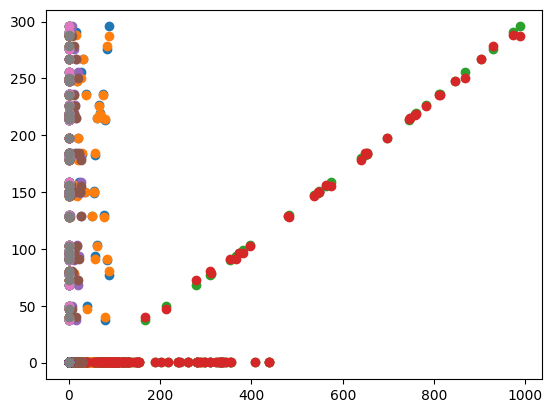

In [ ]:
# Visualising the Random Forest Regression results
# Revenue

for i in range(9):
  plt.scatter(X_valid[:,i], y_valid[:,0]/1000)
  plt.scatter(X_valid[:,i], prediction[:,0]/1000)



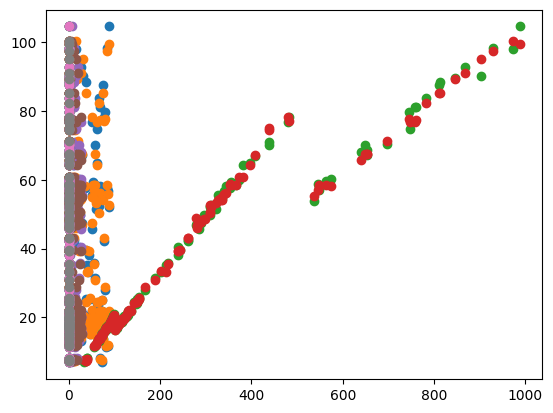

In [ ]:
# Cost
for j in range(9):
  plt.scatter(X_valid[:,j], y_valid[:,1]/1000)
  plt.scatter(X_valid[:,j], prediction[:,1]/1000)